In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pyspark
import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp, expr, collect_list, struct
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pandas as pd
import numpy as np

def plottar_grafico(x, y, xlabel = '', ylabel = '', rotation = 0, plotTimeStamp = 0, label = False, title = False):
    # Plotar o gráfico
    fig, ax = plt.subplots()
    if(not label):
        ax.plot(x, y)
    else:
        ax.plot(x, y, label=label)
        
    if(title):
        ax.set_title(title)

    # Formatar o eixo x para exibir a data/hora
    if plotTimeStamp:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
    plt.xticks(rotation=rotation)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    plt.show(block=False)

In [2]:
def filter_last_n_blocks(df, atual_block_id, n):
    min_block_id = atual_block_id - n
    filtered_df = df.filter((df["Block_ID"] >= min_block_id) & (df["Block_ID"] < atual_block_id))
    return filtered_df

def get_dataframes(num_last_blocks = 50):
    block_df = None
    file_path = "../Scripts/output/block/block.csv"
    # Ler o arquivo CSV
    block_df = spark.read.csv(file_path, header=True, inferSchema=True)
    
    swap_df = None
    file_path = "../Scripts/output/swap/swap_transactions.csv"
    # Ler o arquivo CSV
    swap_df = spark.read.csv(file_path, header=True, inferSchema=True)
    
    transaction_df = None
    file_path = "../Scripts/output/transaction/transactions.csv"
    # Ler o arquivo CSV
    transaction_df = spark.read.csv(file_path, header=True, inferSchema=True)
    
    last_block = block_df.agg(F.max("Block_ID")).collect()[0][0]
    
    block_df = filter_last_n_blocks(block_df, last_block, num_last_blocks)
    transaction_df = filter_last_n_blocks(transaction_df, last_block, num_last_blocks)
    swap_df = filter_last_n_blocks(swap_df, last_block, num_last_blocks)
    
    return block_df, transaction_df, swap_df

In [3]:
def to_null(c):
    return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))

def clean_swap_dataframe(swap_df):
    swap_df_cleaned = swap_df.select([to_null(c).alias(c) for c in swap_df.columns]).na.drop()

    swap_df_cleaned = swap_df_cleaned.withColumn("From_Token_Price", when(col("From_Token_Price") == 0, float('nan')).otherwise(col("From_Token_Price")))
    swap_df_cleaned = swap_df_cleaned.withColumn("To_Token_Price", when(col("To_Token_Price") == 0, float('nan')).otherwise(col("To_Token_Price")))
    
    return swap_df_cleaned

In [4]:
def combine_dataframes(block_df, transaction_df, swap_df_cleaned):
    combined_altered_df = block_df.drop("Gas_Limit")
    combined_altered_df = combined_altered_df.drop("Gas_Used")
    combined_altered_df = combined_altered_df.drop("Timestamp_Block")
    df_combined = block_df.join(transaction_df, "Block_ID").join(swap_df_cleaned, "Hash_Transaction")
    
    return df_combined

In [5]:
def spark_shape(self):
    return (self.count(), len(self.columns))
pyspark.sql.dataframe.DataFrame.shape = spark_shape

def get_gas(transaction_df):
    transaction_df_altered = transaction_df.withColumn('Timestamp_Transaction', to_timestamp(col('Timestamp_Transaction')))

    # Criar a coluna Gas_Utilizado, no qual Gas_Utilizado é o preço do gás vezes o limite
    transaction_df_altered = transaction_df_altered.withColumn("Transaction_Fee", expr("Gas_Price * Gas_Used"))

    # Calcular a média de 'Gás_Usado' agrupada por data e hora
    grouped_df = transaction_df_altered.groupBy('Timestamp_Transaction').mean('Transaction_Fee')

    # Ordenar os valores pela coluna 'Timestamp_Transacao'
    ordered_df = grouped_df.orderBy('Timestamp_Transaction')
    
    # Obter os valores das colunas 'Timestamp_Transacao' e 'avg(Gás_Usado)' em listas
    # timestamps = ordered_df.select('Timestamp_Transaction').rdd.flatMap(lambda x: x).collect()
    # avg_gas_used = ordered_df.select('avg(Transaction_Fee)').rdd.flatMap(lambda x: x).collect()
    
    timestamps = [val['Timestamp_Transaction'] for val in ordered_df.select('Timestamp_Transaction').collect()]
    avg_gas_used = [val['avg(Transaction_Fee)'] for val in ordered_df.select('avg(Transaction_Fee)').collect()]
        
    return timestamps, avg_gas_used

In [6]:
from pyspark.sql.functions import avg

def get_holders_most_purchased_coins(df_combined):
    # Obtenha as 10 moedas mais compradas
    top_10_compradas = df_combined.filter(df_combined.To_Token_Symbol.isNotNull()) \
                                 .groupBy("To_Token_Symbol") \
                                 .count() \
                                 .orderBy(F.desc("count")) \
                                 .limit(10) \
                                 .select(col("To_Token_Symbol").alias("Token_Symbol"))

    # Obtenha as transações de compra de determinada moeda e o número de holders
    compras_df = df_combined.alias("compras") \
                           .join(top_10_compradas, top_10_compradas.Token_Symbol == col("compras.To_Token_Symbol"), "inner") \
                           .select("compras.Timestamp_Transaction", "compras.To_Token_Symbol", "compras.To_Token_Holders_Count") \
                           .withColumnRenamed("To_Token_Symbol", "Token_Symbol") \
                           .withColumnRenamed("To_Token_Holders_Count", "Token_Holders_Count")

    # Obtenha as transações de venda de determinada moeda e o número de holders
    vendas_df = df_combined.alias("vendas") \
                          .join(top_10_compradas, top_10_compradas.Token_Symbol == col("vendas.From_Token_Symbol"), "inner") \
                          .select("vendas.Timestamp_Transaction", "vendas.From_Token_Symbol", "vendas.From_Token_Holders_Count") \
                          .withColumnRenamed("From_Token_Symbol", "Token_Symbol") \
                          .withColumnRenamed("From_Token_Holders_Count", "Token_Holders_Count")

    result_df = compras_df.unionAll(vendas_df)
    
    # Agrupe o dataframe e calcule o número médio de holders para cada moeda em cada timestamp
    grouped_df = result_df.groupBy("Timestamp_Transaction", "Token_Symbol").agg(avg("Token_Holders_Count").alias("average_holders_count"))

    # Ordene o dataframe pelo campo "Timestamp_Transaction"
    sorted_df = grouped_df.orderBy("Timestamp_Transaction")

    # Coleta os dados do dataframe para uso no matplotlib
    data_dict = {}

    # Agrupe o dataframe e obtenha os valores de média de holders para cada moeda em cada timestamp
    grouped_df = sorted_df.groupBy("Token_Symbol").agg(collect_list(struct("Timestamp_Transaction", "average_holders_count")).alias("data_list"))

    # Converta o resultado em um dicionário
    data_dict = {row["Token_Symbol"]: {"timestamps": [r["Timestamp_Transaction"] for r in row["data_list"]],
                                       "holders_counts": [r["average_holders_count"] for r in row["data_list"]]}
                 for row in grouped_df.collect()}
    
    return data_dict

In [7]:
import warnings
import datetime
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM

warnings.filterwarnings("ignore", category=FutureWarning)

def denormalize_data(scaler, normalized_data):
    # Desnormalizar os dados usando o scaler
    return scaler.inverse_transform(normalized_data)

def generate_period(next_n_periods, series):
    # Calculando o próximo horário após o último período da série
    last_datetime = series.index[-1]
    x_test = []

    for i in range(next_n_periods):
        next_datetime = last_datetime + pd.Timedelta(minutes=30)
        x_test.append(next_datetime)
        last_datetime = next_datetime

    # Retorna a lista de horários para os próximos n períodos após o último período da série
    return x_test

def data_generator(normalized_series, window_size, next_n_periods):
    data = normalized_series.values
    data_length = len(data)
    
    for i in range(data_length - window_size - next_n_periods + 1):
        window = data[i:i + window_size]  # Obtém a janela de tamanho N
        
        for j in range(next_n_periods):
            yield window
            next_value = model.predict(window.reshape(1, window_size, 1))  # Faz a previsão do próximo valor
            window = np.append(window[1:], next_value)  # Atualiza a janela para incluir a previsão

def estimate_price(dates, prices):
    
    # Converter as listas para pandas Series
    series = pd.Series(prices, index=dates)

    # Agrupar os preços em janelas de 30 minutos e calcular a média
    averaged_series = series.resample('30T').mean().ffill()
    
    # Normalizar os dados usando MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Normalizar os valores do dataframe com o MinMax
    normalized_values = scaler.fit_transform(averaged_series.values.reshape(-1, 1))

    # Criar um novo dataframe com os dados normalizados
    normalized_series = pd.Series(normalized_values.flatten(), index=averaged_series.index)
    
    # Fixar o tamanho da janela em 5 períodos anteriores
    window_size = int(len(averaged_series)/2)

    # Criar o conjunto de dados de treinamento com as janelas e as saídas correspondentes
    x_train, y_train = [], []
    for i in range(window_size, len(normalized_series)):
        x_train.append(normalized_series[i - window_size:i].values)
        y_train.append(normalized_series[i])
    
    print(x_train)
    print(y_train)
    sys.exit()

    x_train, y_train = np.array(x_train), np.array(y_train)

    x_train = scaler.fit_transform(x_train)
    y_train = scaler.fit_transform(y_train.reshape(-1, 1))

    # Remodelar os dados para o formato esperado pelo LSTM (número de amostras, tamanho da janela, número de atributos)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Criar o modelo LSTM
    model = Sequential()
    model.add(LSTM(units=100, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.add(Activation('relu'))

    # Compilar o modelo
    model.compile(loss="mse", optimizer="adam")

    # Treinar o modelo
    model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1, shuffle=True)
    pre_inputs = generate_period(3, averaged_series)
    
    # Últimos 5 períodos da série para fazer as previsões
    last_n_periods = averaged_series[-window_size:].index.tolist()

    # Concatenar os últimos 5 períodos com o conjunto de teste x_test
    inputs = last_n_periods + pre_inputs
    
    inputs = np.array([pd.Timestamp.to_pydatetime(dt).timestamp() for dt in inputs])
             
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    
    X_test = []
    for i in range(window_size,inputs.shape[0]):
        X_test.append(inputs[i-window_size:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    
    predicted_prices_normalized = model.predict(X_test)

    # Desnormalizar as previsões para obter os preços originais
    predicted_prices = denormalize_data(scaler, predicted_prices_normalized)
    

    # Imprimir as previsões para os próximos n períodos
    for i, datetime in enumerate(X_test):
        print(f"Previsão de preço para o período {pre_inputs[i]}: {predicted_prices[i][0]}")

In [8]:
def get_price_variation(df_combined, coin):
    # Filtrar as colunas relevantes para preço e símbolo da criptomoeda
    df_filtered = df_combined.select("Timestamp_Transaction", "To_Token_Price", "To_Token_Symbol", "From_Token_Price", "From_Token_Symbol")

    # Filtrar transações de compra e venda para a moeda desejada
    df_coin = df_filtered.filter((df_filtered["To_Token_Symbol"] == coin) | (df_filtered["From_Token_Symbol"] == coin))

    # Obter a coluna de preço com base na moeda desejada
    df_coin = df_coin.withColumn("Price", when(df_coin["To_Token_Symbol"] == coin, df_coin["To_Token_Price"]).otherwise(df_coin["From_Token_Price"]))

    # Renomear a coluna de símbolo para a moeda desejada
    df_coin = df_coin.withColumn("Symbol", when(df_coin["To_Token_Symbol"] == coin, df_coin["To_Token_Symbol"]).otherwise(df_coin["From_Token_Symbol"]))

    # Calcular a soma dos preços agrupada por timestamp
    df_sum = df_coin.groupBy("Timestamp_Transaction").sum("Price").withColumnRenamed("sum(Price)", "Total_Price")

    # Calcular a contagem de transações agrupada por timestamp
    df_count = df_coin.groupBy("Timestamp_Transaction").count().withColumnRenamed("count", "Transaction_Count")

    # Juntar os dataframes de soma e contagem pelo timestamp
    df_merged = df_sum.join(df_count, "Timestamp_Transaction")

    # Calcular a média de preço por timestamp
    df_avg = df_merged.withColumn("Avg_Price", df_merged["Total_Price"] / df_merged["Transaction_Count"])

    # Ordenar por timestamp
    df_sorted = df_avg.orderBy("Timestamp_Transaction")

    # Coletar os dados do dataframe para uso no matplotlib
    timestamps = [row["Timestamp_Transaction"] for row in df_sorted.collect()]
    avg_prices = [row["Avg_Price"] for row in df_sorted.collect()]
    
    # print(avg_prices)

    # Converter os timestamps em formato Unix para formato de data e hora
    dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
    
    # print(dates)

    return dates, avg_prices

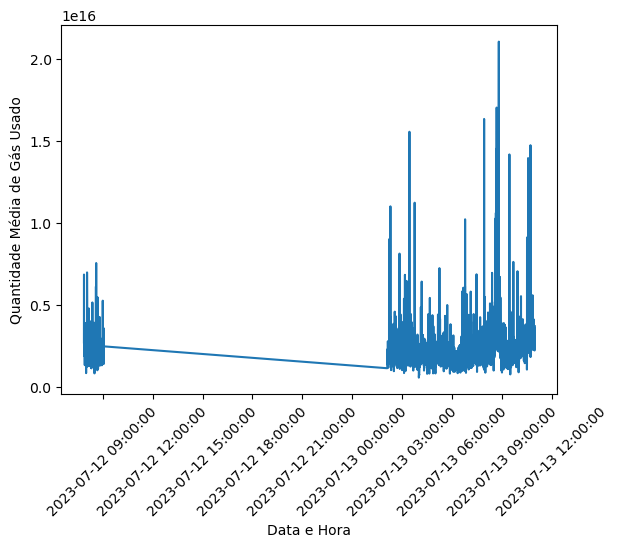

Wolf









[array([0.        , 0.30529423, 0.072422  , 0.46502956, 0.38680389,
       0.70491984, 1.        , 0.73832839, 0.58405738]), array([0.30529423, 0.072422  , 0.46502956, 0.38680389, 0.70491984,
       1.        , 0.73832839, 0.58405738, 0.35046023]), array([0.072422  , 0.46502956, 0.38680389, 0.70491984, 1.        ,
       0.73832839, 0.58405738, 0.35046023, 0.28542078]), array([0.46502956, 0.38680389, 0.70491984, 1.        , 0.73832839,
       0.58405738, 0.35046023, 0.28542078, 0.57720045]), array([0.38680389, 0.70491984, 1.        , 0.73832839, 0.58405738,
       0.35046023, 0.28542078, 0.57720045, 0.44422631]), array([0.70491984, 1.        , 0.73832839, 0.58405738, 0.35046023,
       0.28542078, 0.57720045, 0.44422631, 0.30127853]), array([1.        , 0.73832839, 0.58405738, 0.35046023, 0.28542078,
       0.57720045, 0.44422631, 0.30127853, 0.3269191 ]), array([0.73832839, 0.58405738, 0.35046023, 0.28542078, 0.57720045,
       0.44422631, 0.30127853, 0.3269191 , 0.46962

SystemExit: 

C:\ProgramData\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output
from pyspark.sql.functions import col, isnan, when, trim
from pyspark.sql import functions as F

import os
import sys
from pyspark.sql import SparkSession

output_folder = "../Scripts/output"

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
num_last_blocks = 10000

spark = SparkSession.builder \
    .appName("Análise de Transações Ethereum") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

while True:
    clear_output(wait=True)
    
    block_df, transaction_df, swap_df = get_dataframes(num_last_blocks)
    timestamps, avg_gas_used = get_gas(transaction_df)
    plottar_grafico(timestamps, avg_gas_used, 'Data e Hora', 'Quantidade Média de Gás Usado', 45, 1)
    
    swap_df_cleaned = clean_swap_dataframe(swap_df)
    df_combined = combine_dataframes(block_df, transaction_df, swap_df_cleaned)
    data_dict = get_holders_most_purchased_coins(df_combined)
    for symbol, data in data_dict.items():
        timestamps = data["timestamps"]
        holders_counts = data["holders_counts"]

        # Converte os timestamps em formato Unix para formato de data e hora
        dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
        
        dates_price_variation, avg_prices = get_price_variation(df_combined, symbol)
        print(symbol)
        print('\n\n\n\n\n\n\n\n')
        estimate_price(dates_price_variation, avg_prices)
        plottar_grafico(dates_price_variation, avg_prices, 'Timestamp', 'Preço', 45, 0, symbol, f"Variação de preço da moeda {symbol} ao longo do Tempo")
        plottar_grafico(dates, holders_counts, 'Timestamp', 'Número Médio de Holders', 45, 0, symbol, f"Número Médio de Holders para a Moeda {symbol} ao longo do Tempo")
    plt.pause(25)
    time.sleep(25)